In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt

# to import the files in path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.arbitrage import *
from src.hyphen_liquidity_pools import *

Let's define the following:
- $a$ the amount that we deposit and want to transfer
- $r(x)$ the reward received from the incentive pool for depositingan amount  $x$
- $g$ the gas fees paid on chain (does not depend on the amount deposited/transferred)
- $f(x)$ the transfer fees (both for LP and IP) for transfering an amount $x$

Then the amount received on the toChain is given by:

$$output = a+r - f(a) - g$$

In [2]:
check_arbitrage_opportunities()

New best arbitrage detected for ETH on Ethereum: 
    - Profit=$ 0.0023 
    - Amount In= 0.0075 ETH ~$ 10.0


(0.00225540401791265,
 -1.226788805e-09,
 'Ethereum',
 '0xEeeeeEeeeEeEeeEeEeEeeEEEeeeeEeeeeeeeEEeE')

Making sure we get the same curve fee as describeded in Biconomy's documentation

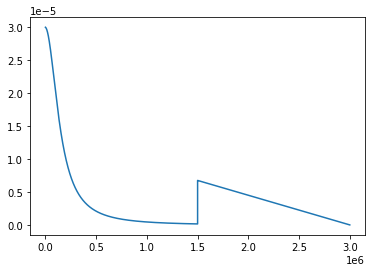

In [21]:
fees=[]
lr=[]
excess_state_transfer_fee = 0.045
for amount in range(0,3000000):
    f = compute_transfer_fee(amount, 3000000,1500000,0.1,0.001,excess_state_transfer_fee=excess_state_transfer_fee,depth=2)
    fees.append(f)
    lr.append(3000000-amount)
plt.plot(lr[::-1], fees[::-1])

In [11]:
# expect true
fees.index(0.001)==1500000

True

In [1]:
# expect true
max(fees)<=0.1

NameError: name 'fees' is not defined

## Show unbalances

In [6]:
blockchain_from = 'Ethereum'
supported_assets.loc[supported_assets['Blockchain'] == blockchain_from]

,Asset,Blockchain,Address
2,BICO,Ethereum,0xF17e65822b568B3903685a7c9F496CF7656Cc6C2
9,ETH,Ethereum,0xEeeeeEeeeEeEeeEeEeEeeEEEeeeeEeeeeeeeEEeE
16,USDC,Ethereum,0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48
23,USDT,Ethereum,0xdAC17F958D2ee523a2206206994597C13D831ec7


Ethereum_BICO
     307393956607080597271369
     357331666000000000000000
Ethereum_ETH
     326843619038003839058
     549726000000000000000
Ethereum_USDC
     537891896418
     737099017000
Ethereum_USDT
     149879712889
     191767303000
Polygon_BICO
     482087060510461401029210
     379901135000000000000000
Polygon_ETH
     255017021385790991130
     280933000000000000000
Polygon_USDC
     480632409579
     480702217000
Polygon_USDT
     245603279401
     239370589100
Avalanche_ETH
     22060197898101260033
     24594000000000000000
Avalanche_USDC
     369820035213
     280990900000
Avalanche_USDT
     31294469218
     30113283000
BSC_BICO
     771812399738418155147298
     750000000000000000000000
BSC_ETH
     443118266614963815846
     51443000000000000000
BSC_USDC
     497666837982680367125124
     381520472000000000000000
BSC_USDT
     415852105756498565711090
     365862688000000000000000
Optimism_BICO
     732060269905737721318675
     750000000000000000000000
Optimism_ETH
 

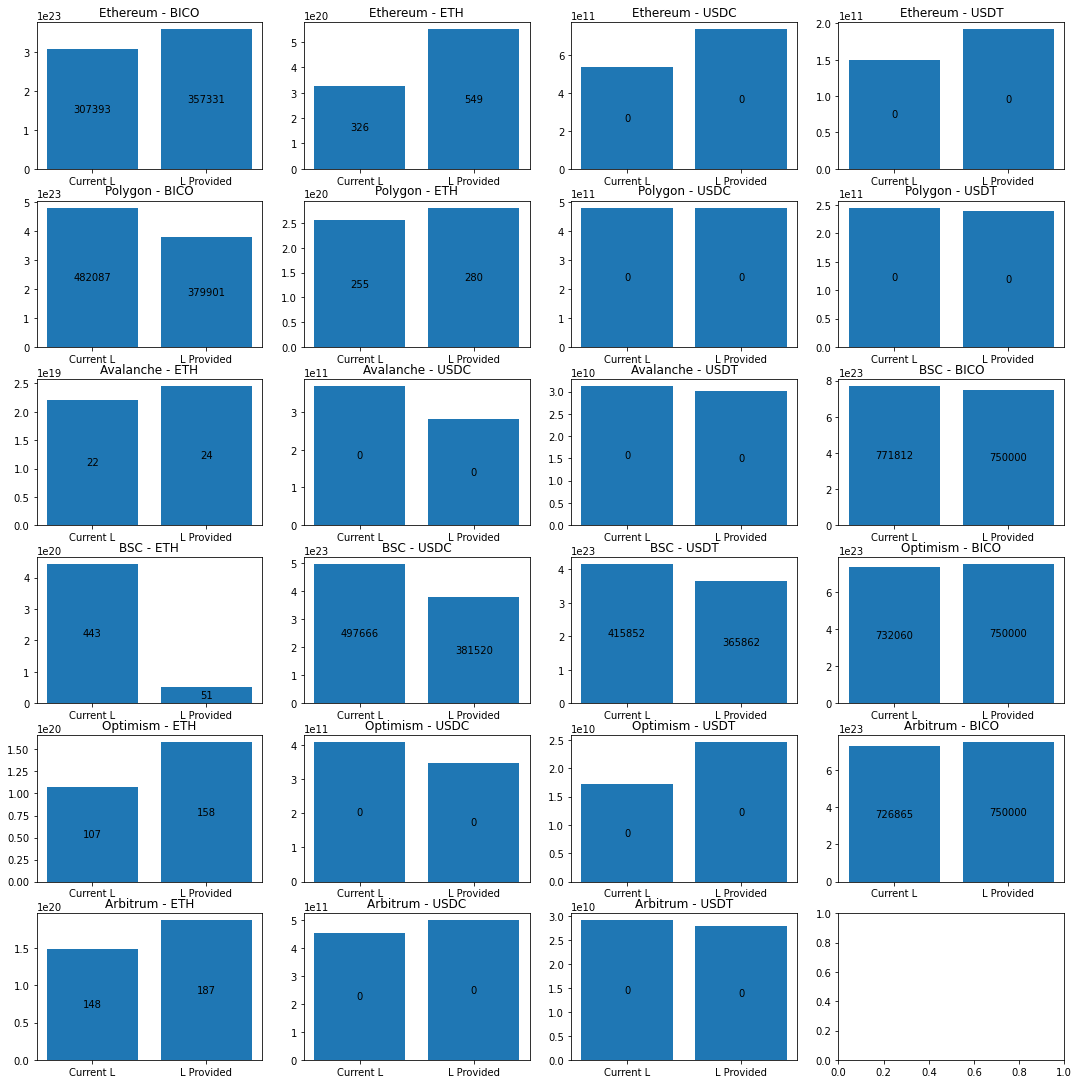

In [19]:
from src.read import *
from src.arbitrage import *
liquidity_pools = read_liquidity_pools()
supported_assets = read_supported_assets()
rpcs = get_rpcs(liquidity_pools)
max_profit = -1
amount_in = 0.0
best_opportunity_blockchain = ''
best_opportunity_asset = ''
assets = supported_assets['Asset'].tolist()
asset_prices = get_prices(assets)
wallet_balance_eth = get_wallet_balance_eth()
wallet_balance_usdc = wallet_balance_eth * asset_prices["USDC"]

fig, axs = plt.subplots(6,4, figsize=(15, 15), facecolor='w', edgecolor='k')
fig.tight_layout()
axs = axs.ravel()
j=0
for blockchain in list(rpcs.keys()):
    api = rpcs[blockchain]
    supported_assets_from = supported_assets.loc[supported_assets['Blockchain'] == blockchain]
    for i, supported_assets_row in supported_assets_from.iterrows():
        asset = supported_assets_row['Address']
        asset_symbol = supported_assets_row['Asset']
        asset_price = asset_prices[asset_symbol]
        equilibrium_liquidity = api.get_equilibrium_liquidity(asset)
        liquidity = api.get_current_liquidity(asset)
        print(blockchain+"_"+asset_symbol)
        print("    ",liquidity)
        print("    ",equilibrium_liquidity)
        incentive_pool = api.get_rewards(asset)
        axs[j].bar(['Current L','L Provided'],[liquidity,equilibrium_liquidity])
        axs[j].text(x='Current L', y=liquidity/2,            s=int(liquidity/1e18),horizontalalignment='center',verticalalignment='center')
        axs[j].text(x='L Provided',y=equilibrium_liquidity/2,s=int(equilibrium_liquidity/1e18),horizontalalignment='center',verticalalignment='center')
        axs[j].set_title(blockchain+" - "+asset_symbol)
        j+=1
        

### TESTS

In [70]:
import json
from pathlib import Path

from web3 import Web3

from src.constants import PATH_TO_PASSWORDS, PATH_TO_DATA
key = Path(PATH_TO_PASSWORDS + 'POKT_KEY.txt').read_text().replace('\n', '')
pk1 = Path(PATH_TO_PASSWORDS + 'pk1.txt').read_text().replace('\n', '')
blockchain_gateway = 'eth-goerli'
url = 'https://eth-rinkeby.gateway.pokt.network/v1/lb/62b2cdf2123e6f00397e943e'
w3 = Web3(Web3.HTTPProvider(url))

In [80]:
def send_tx(address_from, pk_from, address_to, amount):
    account_from = {
        "private_key": pk_from,
        "address": address_from,
    }

    w3.eth.set_gas_price_strategy(rpc_gas_price_strategy)
    tx_create = w3.eth.account.sign_transaction(
        {
            "nonce": w3.eth.get_transaction_count(account_from["address"]),
            "gasPrice": 150000000000,
            "gas": 3000000,
            "to": address_to,
            "value": amount,
            'chainId': w3.eth.chain_id,
        },
        account_from["private_key"],
    )

    # 6. Send tx and wait for receipt
    tx_hash = w3.eth.send_raw_transaction(tx_create.rawTransaction)
    tx_receipt = w3.eth.wait_for_transaction_receipt(tx_hash)

    print(f"Transaction successful with hash: { tx_receipt.transactionHash.hex() }")

In [76]:
address_from = '0xc5324030Ad7e485fD7f42DBDEb1611C3BfE97569'
address_to = '0x4dD079d0A3B9B862D77421558c7c4E13f3a9cBc0'
amount = w3.eth.get_balance(address_from)/2
amount

2.5e+17

In [77]:
send_tx(address_from, pk1, address_to, 20)

Transaction successful with hash: 0x6ad4e5c9c0b60d232d0f68620f074e3f84b816f6f5f01af9fff72ac20672d789


In [ ]:
anyswap_address = '0x273a4fFcEb31B8473D51051Ad2a2EdbB7Ac8Ce02'
